In [1]:
import numpy as np
import cv2
import pandas as pd
import torch
from torchvision import transforms
# from torch.utils.data import Dataset
from PIL import Image, ImageDraw 
import itertools
import random
import argparse
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import os
import matplotlib.pyplot as plt
import time

### process data

In [2]:
def parse_line(line):
    line_parts = line.tolist()
    img_name = line_parts[0]
    landmarks = list(map(int, line_parts[1: len(line_parts)]))
    return img_name, landmarks

In [3]:
class Normalize(object):
    """
        Resieze to train_boarder x train_boarder. Here we use 224 x 224
        Then do channel normalization: (image - mean) / std_variation
    """
    def __init__(self,train_boarder= 224):
        self.train_boarder = train_boarder
    def __call__(self,sample):
        img, landmask = sample['image'], sample['landmarks']
        img_resize = np.asarray(img.resize((self.train_boarder, self.train_boarder),Image.BILINEAR))
        return {'image':img_resize,'landmarks':landmask}

In [4]:
class FlipHorizontal(object):
    '''
    flip horizontal
    '''
    def __init__(self,p= 0.5, train_boarder= 224):
        self.p = p
        self.train_boarder = train_boarder
    def __call__(self,sample):
        img, landmask = sample['image'], sample['landmarks']
        if random.random() < self.p:
            img = img[:,::-1].copy()
            landmask[0::2] = self.train_boarder - landmask[0::2].copy()
        return {'image':img,'landmarks':landmask}

In [5]:
class RandomRotation(object):
    '''
    RandomRotation(0,15)
    '''
    def __init__(self, train_boarder= 224, p= 0.5):
        self.train_boarder = train_boarder
        self.p = p
    def __call__(self,sample):
        img, landmask = sample['image'], sample['landmarks']
        if random.random() < self.p:
            ang = random.randint(-5, 5)
            scale = 1.0
            M = cv2.getRotationMatrix2D((self.train_boarder/2, self.train_boarder/2), ang, scale)
            img = cv2.warpAffine(img, M, (self.train_boarder,self.train_boarder), flags= cv2.INTER_LINEAR)
            xs = landmask[::2].copy()
            ys = landmask[1::2].copy()
        
            #opencv获得的旋转矩阵是调整过的，需要注意
            mxy = (np.c_[xs,ys] - np.array([self.train_boarder/2, self.train_boarder/2])) 
            xys = (mxy.dot( np.transpose( M[:,:2] ) ) + np.array([self.train_boarder/2, self.train_boarder/2]))
        
            landmask[::2] = xys[:,0]
            landmask[1::2] = xys[:,1]
        return {'image':img,'landmarks':landmask}


In [6]:
class ToTensor(object):
    """
        Convert ndarrays in sample to Tensors.
        Tensors channel sequence: N x C x H x W
    """
    def __call__(self,sample):
        '''
        numpy img: H*W*C
        torch.tensorimg: N*C*H*W
        '''
        img, landmarks = sample['image'], sample['landmarks']
#         如果不是灰度图要改变维度
        img = img.transpose((2, 0, 1))
#         img = np.expand_dims(img, axis=0)
        return {'image':torch.from_numpy(img).float(), 
                'landmarks':torch.from_numpy(landmarks).float()}

In [7]:
class FaceLandmarksDataset():
    def __init__(self, data, transforms= None, train_boarder= 224, cache_in_memory=True):
        '''
        :param lines: src_line
        :param transform: data transform
        '''
        self.data = data
        self.transforms = transforms
        self.train_boarder = train_boarder
        if cache_in_memory:
            self.cache = {}
        else:
            self.cache = None
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if self.cache is not None:
            sample = self.cache.get(idx)
            if sample is not None:
                sample = self.transforms(sample)
                return sample
        img, landmarks = parse_line(self.data.values[idx])
        #转为灰度图
        img = Image.open(img)
        landmarks = np.array(landmarks).astype('float64')
        
        #对lanmarks做变换
        w = img.width
        h = img.height
        
        k_w = self.train_boarder/w
        k_h = self.train_boarder/h
        
        landmarks[::2] *= k_w
        landmarks[1::2] *= k_h
        
        sample = {'image':img, 'landmarks':landmarks}
    
        if self.cache is not None:
            self.cache[idx] = sample
        
        sample = self.transforms(sample)
        return sample

In [8]:
def load_data(filepath, phase):
    '''
    加载数据
    '''
    df = pd.read_csv(filepath)
    if phase == 'Train' or phase == 'train':
        tsfm = transforms.Compose([
            Normalize(),                # do channel normalization
            FlipHorizontal(),           # do Flip Horizontal
            RandomRotation(),           # do Random Rotation
            ToTensor()]                 # convert to torch type: NxCxHxW
        )
    else:
        tsfm = transforms.Compose([
            Normalize(),
            ToTensor()]
        )
    data_set = FaceLandmarksDataset(df, transforms= tsfm)
    return data_set


In [9]:
def get_train_test_set():
    train_set = load_data('data/train_annotation.csv','train')
    valid_set = load_data('data/test_annotation.csv','test')
    return train_set, valid_set

In [10]:
def drawLandMarks(path, idx):
    '''
    在resize后的图上画出landmarks
    '''
    dataset = load_data(path, 'train')
    
    sample = dataset[idx]
    img = transforms.ToPILImage()(sample['image'].type(torch.uint8))
    landmarks = sample['landmarks'].numpy()
    xs = landmarks[::2]
    ys = landmarks[1::2]
    
    draw = ImageDraw.Draw(img)
    draw.point(list(zip(xs,ys)),fill = (255))
    img.show()
    return img

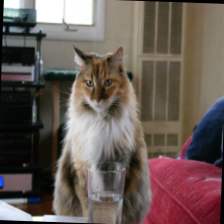

In [11]:
if __name__ == '__main__':
    path= 'data/train_annotation.csv'
    img = drawLandMarks(path= path, idx= 8)
img

### Network

In [12]:
class Net_Bn(nn.Module):
    def __init__(self):
        super(Net_Bn, self).__init__()

        avgPool = nn.AvgPool2d(kernel_size=2, stride=2, ceil_mode=True)

        # 1*224*224 -> 8*110*110
        self.conv1_1 = nn.Conv2d(3, 8, kernel_size=5, stride=2)
        self.prelu1_1 = nn.PReLU()
        # 8*110*110 -> 8*55*55
        self.pool1 = avgPool

        # 8*55*55 -> 16*55*55
        self.conv2_1 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.prelu2_1 = nn.PReLU()
        # 16*55*55 -> 16*53*53
        self.conv2_2 = nn.Conv2d(16, 16, kernel_size=3)
        self.prelu2_2 = nn.PReLU()
        # 16*53*53 -> 16*27*27
        self.pool2 = avgPool

        # 16*27*27 -> 24*25*25
        self.conv3_1 = nn.Conv2d(16, 24, kernel_size=3)
        self.prelu3_1 = nn.PReLU()
        # 24*25*25 -> 24*23*23
        self.conv3_2 = nn.Conv2d(24, 24, kernel_size=3)
        self.prelu3_2 = nn.PReLU()
        # 24*23*23 -> 24*12*12
        self.pool3 = avgPool

        # 24*12*12 -> 40*10*10
        self.conv4_1 = nn.Conv2d(24, 40, kernel_size=3)
        self.prelu4_1 = nn.PReLU()
        # 40*10*10 -> 80*8*8
        self.conv4_2 = nn.Conv2d(40, 80, kernel_size=3)
        self.prelu4_2 = nn.PReLU()


        self.ip1 = nn.Linear(80 * 8 * 8, 128)
        self.preluip1 = nn.PReLU()
        self.ip2 = nn.Linear(128, 128)
        self.preluip2 = nn.PReLU()
        self.bn_ip3 =  nn.BatchNorm1d(128)
        self.ip3 = nn.Linear(128, 18)

    def forward(self, x):
        """
        x: (:,3,224,224)
        retVal: (1, 18)
        """
        x = self.prelu1_1(self.conv1_1(x))
#         print(x.shape)
        x = self.pool1(x)
#         print(x.shape)
        x = self.prelu2_1(self.conv2_1(x))
        x = self.prelu2_2(self.conv2_2(x))
        x = self.pool2(x)
#         print(x.shape)
        x = self.prelu3_1(self.conv3_1(x))
        x = self.prelu3_2(self.conv3_2(x))
        x = self.pool3(x)
#         print(x.shape)
        x = self.prelu4_1(self.conv4_1(x))
        x = self.prelu4_2(self.conv4_2(x))
#         print(x.shape)
        x = x.view(-1, 80 * 8 * 8)
        x = self.preluip1(self.ip1(x))
        
        x = self.preluip2(self.ip2(x))

        x = self.bn_ip3(x)
        x = self.ip3(x)

        return x

### detector

In [13]:
def model_parameters_init(model):
    '''
    kaiming init
    '''
    for p in model.parameters():
        if len(p.shape) >= 2:
            nn.init.kaiming_normal_(p)
    return model

In [14]:
def train(args, train_loader, valid_loader, model, criterion, optimizer, scheduler, device):
    #save model or not
    if args.save_model:
        if not os.path.exists(args.save_directory):
            os.makedirs(args.save_directory)
    
    epochs = args.epochs
    pts_criterion = criterion
    
    train_losses = []
    valid_losses = []
    for epoch_id in range(epochs):
        #monitor training loss
        train_loss = 0.0
        valid_loss = 0.0
        model.train()
        ######################
        #training the model#
        ######################
        train_batch_cnt = 0
        for batch_idx, batch in enumerate(train_loader):
            train_batch_cnt += 1
            img = batch['image']
            landmarks = batch['landmarks']
            
            # groundtruth
            input_img = img.to(device)
            target_pts = landmarks.to(device)
            
            #clear the gradients of all optimized variables
            optimizer.zero_grad()
            
            #get out_put
            #print(input_img.dtype)
            output_pts = model(input_img)
            
            #get loss
            loss = pts_criterion(output_pts, target_pts)
            train_loss += loss.item()
            
            #do bp
            loss.backward()
            optimizer.step()
            
            #show log info
            if batch_idx % args.log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]  pts_loss: {:.6f}'.format(
                        epoch_id,
                        batch_idx * len(img),
                        len(train_loader.dataset),
                        100. * batch_idx / len(train_loader),
                        loss.item()
                        )
                      )
        #记录train_loss
        train_loss /= train_batch_cnt
        train_losses.append(train_loss)
            
        ######################
        # validate the model #
        ######################
        valid_loss = 0.0
        #change model mode to eval ,not ues BN/Dropout
        model.eval()
        with torch.no_grad():
            valid_batch_cnt = 0
            
            for valid_batch_idx, batch in enumerate(valid_loader):
                valid_batch_cnt += 1
                valid_img = batch['image']
                landmarks = batch['landmarks']
                
                input_img = valid_img.to(device)
                target_pts = landmarks.to(device)
                
                output_pts = model(input_img)
                
                valid_loss_batch = pts_criterion(output_pts, target_pts)
                valid_loss += valid_loss_batch.item()
            
            valid_loss /= valid_batch_cnt * 1.0
            #记录valid_loss
            valid_losses.append(valid_loss)
            print('Valid: pts_loss: {:.6f}'.format(valid_loss))
            #学习率衰减
            scheduler.step()
        print('===========================================================')
        #save model
        if args.save_model and epoch_id % 10 == 0:
            saved_model_name = os.path.join(args.save_directory, 'detector_epoch' + '_' + str(epoch_id) + '.pt')
            torch.save(model.state_dict(), saved_model_name)
    return train_losses, valid_losses

In [ ]:
def main():
    parser = argparse.ArgumentParser(description='Detector')
    parser.add_argument('--batch_size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 256)')
    parser.add_argument('--test_batch_size', type=int, default=256, metavar='N',
                        help='input batch size for testing (default: 256)')
    parser.add_argument('--predict_batch_size', type=int, default=1, metavar='N',
                        help='input batch size for predict (default: 1)')
    parser.add_argument('--epochs', type=int, default=50, metavar='N',
                        help='number of epochs to train (default: 100)')
    parser.add_argument('--lr', type=float, default=0.001, metavar='LR',
                        help='learning rate (default: 0.001)')
    parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                        help='SGD momentum (default: 0.5)')
    parser.add_argument('--cuda', action='store_true', default=False,
                        help='enables CUDA training')
    parser.add_argument('--seed', type=int, default=10, metavar='S',
                        help='random seed (default: 10)')
    parser.add_argument('--log_interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save_model', action='store_true', default=False,
                        help='save the current Model')
    parser.add_argument('--save_directory', type=str, default='trained_models',
                        help='learnt models are saving here')
    parser.add_argument('--phase', type=str, default='Train',   # Train/train, Predict/predict, Finetune/finetune
                        help='training, predicting or finetuning')
    args = parser.parse_args(['--batch_size=64',
                              '--test_batch_size=64',
                              '--predict_batch_size=1',
                              '--epochs=101',
                              '--lr=0.0001',
                              '--momentum=0.5',
                              '--cuda',
                              '--seed=1',
                              '--log_interval=1',
                              '--save_model',
                              '--save_directory=trained_models',
                              '--phase=train'])
    ##############################################################################################################
    #设置随机种子
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed(args.seed)
    #设置CPU/GPU
    use_cuda = args.cuda and torch.cuda.is_available()
    device = torch.device('cuda' if use_cuda else 'cpu')
    #For multi GPUs, nothing need to change here
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    ###############################################################################################################
    print('===> Loading Datasets')
    train_set, test_set = get_train_test_set()
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=args.batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(test_set, batch_size=args.test_batch_size)
    predict_loader = torch.utils.data.DataLoader(test_set, batch_size=args.predict_batch_size)
    ###############################################################################################################
    print('===> Building Model')
    # For single GPU
    print('===> runing on {}'.format(device))
    ###############################################################################################################
    print('===> init model')
    model = Net_Bn()
    model = model_parameters_init(model)
    ###############################################################################################################
    model.to(device)
    criterion_pts = nn.MSELoss()
#     optimizer = optim.Adam(model.parameters(), lr= args.lr)
    optimizer = optim.SGD(model.parameters(), lr = args.lr, momentum= args.momentum)
    #学习率衰减
    scheduler = optim.lr_scheduler.StepLR(optimizer, 10 , 0.9)
    ###############################################################################################################
    if args.phase == 'Train' or args.phase == 'train':
        print('===> Start Training')
        train_losses, valid_losses = train(args, train_loader, valid_loader, model, criterion_pts, optimizer, scheduler, device)
        print('===> Done!')
        return train_losses, valid_losses
        
    elif args.phase == 'Test' or args.phase == 'test':
        print('===> Test')
        path_model = os.path.join(args.save_directory, 'detector_epoch' + '_' + str(85) + '.pt')
        model.load_state_dict(torch.load(path_model))
        model = model.to(device)
        model.eval()
        with torch.no_grad():
            valid_batch_cnt = 0
            valid_loss = 0
            for valid_batch_idx, batch in enumerate(valid_loader):
                valid_batch_cnt += 1
                valid_img = batch['image']
                landmarks = batch['landmarks']
                
                input_img = valid_img.to(device)
                target_pts = landmarks.to(device)
#                 print(input_img.shape)
                output_pts = model(input_img)
#                 print(type(output_pts))
                
                valid_loss_batch = criterion_pts(output_pts, target_pts)
                valid_loss += valid_loss_batch.item()
            
            valid_loss /= valid_batch_cnt * 1.0
            print('Valid: pts_loss: {:.6f}'.format(valid_loss))
        print('===> Done!')
        return None, None
        
    elif args.phase == 'Finetune' or args.phase == 'finetune':
        print('===> Finetune')
        path_model = os.path.join(args.save_directory, 'detector_epoch' + '_' + str(50) + '.pt')
        model.load_state_dict(torch.load(path_model))
        model = model.to(device)
        train_losses, valid_losses = train(args, train_loader, valid_loader, model, criterion_pts, optimizer, scheduler, device)
        print('===> Done!')
        return train_losses, valid_losses
        
    elif args.phase == 'Predict' or args.phase == 'predict':
        print('===> Predict')
        path_model = os.path.join(args.save_directory, 'detector_epoch' + '_' + str(50) + '.pt')
        model.load_state_dict(torch.load(path_model))
        model = model.to(device)
        model.eval()
        idx = 99
        with torch.no_grad():
            for i,data in enumerate(predict_loader):
                if i == idx:
                    img = data['image'].to(device)
                    output_pts = model(img)
                    landmarks = output_pts[0].numpy()
                    xs = landmarks[::2]
                    ys = landmarks[1::2]
                    img = transforms.ToPILImage()(img[0].type(torch.uint8))
                    draw = ImageDraw.Draw(img)
                    draw.point(list(zip(xs,ys)),fill = (0))
                    img.show()
                elif i > idx:
                    break
        print('===> Done!')
        return None, None

In [ ]:
if __name__ == '__main__':
    np.random.seed(1)
    start = time.time()
    train_losses, valid_losses = main()
    end = time.time()
    print('耗时：{}s'.format(end - start))

In [ ]:
if __name__ == '__main__':
    plt.figure(0,(8,6))
    start = 0
    end = len(train_losses) + 1
    losses_train = train_losses[start:end]
    losses_valid = valid_losses[start:end]
    plt.plot(np.arange(len(losses_train)),losses_train)
    plt.plot(np.arange(len(losses_valid)),losses_valid)
    plt.legend(['train_losses','valid_losses'])
    plt.title('valid_loss:{}'.format(round(losses_valid[-1],2)), fontsize = 15,pad= 15)
#     plt.xlim(8,100)
    plt.xlabel('epochs',fontsize = 15)
    plt.ylabel('loss',fontsize = 15)
    plt.savefig('figure/{}_newnet.jpg'.format(round(losses_valid[-1],2)))
    plt.show()

In [21]:
torch.cuda.is_available()

True